# <font size="7">Lab 2: RCT vs Observational data</font>


In this Lab you will explore the main differences in the ATE's estimation from RCT and observational data. You will study the properties of the IPW and parametric g-formula's estimators through extensive simulations on synthetic data generated as in <a href="https://pubmed.ncbi.nlm.nih.gov/15351954/">(Lunceford & Davidian 2004)</a>.

# Synthetic data - ([Lunceford & Davidian 2004](https://pubmed.ncbi.nlm.nih.gov/15351954/))

We will perform the same simulations proposed in Lunceford & Davidian 2004.

## Generative model

The *response* variable $Y$ is generated according the following equation:
$$  Y = {\nu}_{0} +{\nu}_{1}X_1 +{\nu}_{2}X_2 +{\nu}_{3}X_3 +{\nu}_{4}A+{\xi}_{1}V_1 +{\xi}_{2}V_2 +{\xi}_{3}V_3 + \epsilon, \epsilon \sim \mathcal{N}(0 ,1),$$
where $\nu = {\left({\nu}_{0}, {\nu}_{1}, {\nu}_{2}, {\nu}_{3}, {\nu}_{4}\right)}^{\top} = {\left(0, -1, 1, -1, 2\right)}^{\top}$, $\xi = {\left({\xi}_{1}, {\xi}_{2}, {\xi}_{3}\right)}^{\top} = {\left(-1, 1, 1\right)}^{\top}$. The *covariates* are distributed as
$X_3 \sim \text{Bernoulli}\left(0.2\right)$, and conditionnaly on $X_3$


$\text{If } X_{3} = 0$, $V_3 \sim \text{Bernoulli}\left(0.25\right)$ and
 ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\top} \sim \mathcal{N}({\tau}_{0}, \Sigma)$ 

$\text{If } X_{3} = 1$, $V_3 \sim  \text{Bernoulli}\left(0.75\right)$ and ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\top} \sim \mathcal{N}({\tau}_{1}, \Sigma)$ 
with 
$$ {\tau}_{1} = \left(\begin{array}{c}
1 \\
1 \\
-1\\
-1 
\end{array}\right), {\tau}_{0} = \left(\begin{array}{c}
-1 \\
-1 \\
1\\
1 
\end{array}\right), \text{and}, \Sigma = \left(\begin{array}{cccc}
1 & 0.5 & -0.5 & -0.5\\
0.5 & 1 & -0.5 & -0.5  \\
-0.5 & -0.5 & 1 & 0.5 \\
-0.5 & -0.5 & 0.5 & 1 
\end{array}
\right)$$

and the *treatment* $A$ is generated as a Bernoulli of the *propensity score*
$$e\left(X, \beta\right) = {\{1+\exp\left(- {\beta}_{0} - {\beta}_{1}X_{1} - {\beta}_{2}X_{2} - {\beta}_{3}X_{3}\right)\}}^{-1}$$
with $\beta={\left({\beta}_{0}, {\beta}_{1}, {\beta}_{2}, {\beta}_{3}\right)}^{\top} = {\left(0, 0.6, -0.6, 0.6\right)}^{\top}$.


In [23]:
# Processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import graphviz as gr

# Prediction
import sklearn.ensemble as sklearn_ensemble
import sklearn.linear_model as sklearn_linear_model
import statsmodels.api as sm

# Plot
sns.set(font_scale=1.5)

In [24]:
# Model parameters
XI = np.array([-1, 1, 1])
NU = np.array([0, -1, 1, -1, 2])
BETA = np.array([0, 0.6, -0.6, 0.6])
TAU_0 = np.array([-1, -1, 1, 1])
TAU_1 = TAU_0 * -1
SIGMA = np.array([[1, 0.5, -0.5, -0.5],
                  [0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, 0.5],
                  [-0.5, -0.5, 0.5, 1]], dtype=float)

In [25]:
def generate_lunceford(n=1000):
    # Generate data
    x3 = np.random.binomial(1, 0.2, n)
    v3 = np.random.binomial(1, (0.75 * x3 + (0.25 * (1 - x3))), n)
    
    # If x3=0 you have a model, if x3=1 you have another one
    x1v1x2v2_x3_0_matrix = np.random.multivariate_normal(TAU_0, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3_1_matrix = np.random.multivariate_normal(TAU_1, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3 = np.where(np.repeat(x3[:, np.newaxis], 4, axis=1) == 0, x1v1x2v2_x3_0_matrix, x1v1x2v2_x3_1_matrix)

    # Concatenate values
    xv = np.concatenate([x1v1x2v2_x3, np.expand_dims(x3, axis=1), np.expand_dims(v3, axis=1)], axis=1)
    
    # Compute e, a, and y
    x = xv[:, [0,2,4]]
    v = xv[:, [1,3,5]]
    e = np.power(1 + np.exp(- BETA[0] - x.dot(BETA[1:])), -1)
    a = np.random.binomial(1, e, n)
    y = x.dot(NU[1:-1]) + v.dot(XI) + a*NU[-1] + np.random.binomial(1, e, n) + np.random.normal(0, 1, n)
    
    # Create the final df
    synthetic_data_df = pd.DataFrame(np.concatenate([x, np.expand_dims(a, axis=1), v, np.expand_dims(y, axis=1), np.expand_dims(e, axis=1)], axis=1), columns=["X1", "X2", "X3", "A", "V1", "V2", "V3", "Y", "e"])
    synthetic_data_df["A"] = synthetic_data_df["A"].astype(int)
    
    return synthetic_data_df

In [26]:
simul_pe_data = generate_lunceford(n = 5000)
simul_pe_data.describe()

,X1,X2,X3,A,V1,V2,V3,Y,e
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-0.613563,0.583449,0.206200,0.377800,-0.592749,0.582889,0.356000,3.660386,0.382011
std,1.267672,1.262535,0.404616,0.484886,1.275125,1.290434,0.478863,4.072799,0.276066
min,-4.187440,-3.880100,0.000000,0.000000,-5.270081,-3.897515,0.000000,-10.384683,0.010113
25%,-1.491555,-0.215961,0.000000,0.000000,-1.467212,-0.231898,0.000000,1.201422,0.156967
50%,-0.712215,0.666814,0.000000,0.000000,-0.674126,0.680575,0.000000,3.997851,0.301676
75%,0.170947,1.451745,0.000000,1.000000,0.190228,1.506770,1.000000,6.485178,0.563368
max,4.013316,4.382267,1.000000,1.000000,4.426051,4.698631,1.000000,16.747739,0.993200


### Question 1
The true ATE is equal to $\nu_4=2$. 


Indeed, 
$$\tau = \mathbb{E}[Y(1)-Y(0)] = \mathbb{E}\left[\mathbb{E}[Y(1)-Y(0)|X]\right]$$ 
Under unconfoundness assumption, 
$$\tau = \mathbb{E}\left[\mathbb{E}[Y(1)|X, A=1] - \mathbb{E}[Y(0)|X, A=0]\right]$$ 
Under consistency assumption, 
$$\tau = \mathbb{E}\left[\mathbb{E}[Y|X, A=1] - \mathbb{E}[Y|X, A=0]\right]$$ 


Looking at the data generating process equation for $Y$, one retrieve 
$\tau = 2$

### Question 2

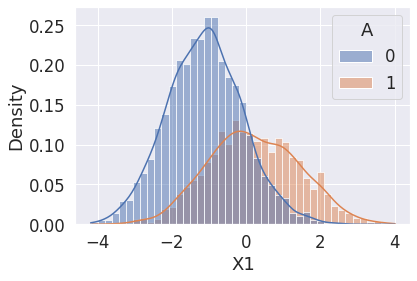

In [27]:
sns.histplot(data=simul_pe_data, x='X1', hue='A', kde=True, stat="density");

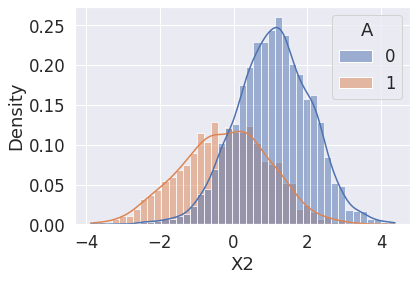

In [28]:
sns.histplot(data=simul_pe_data, x='X2', hue='A', kde=True, stat="density");

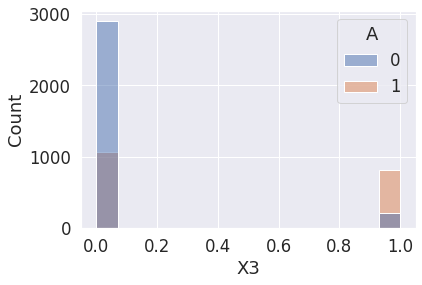

In [29]:
sns.histplot(data=simul_pe_data, x='X3', hue='A');

The treatment allocation is not random, it depends on the covariates. The distribution of the treated and control is not balanced. You could also compute numerical statistics, such as mean, variance, summary per group. 
This indicates that we need to adjust for confounding effects to assess the impact of the treatment.

## Parametric estimation


### Question 3

**(3.1)** 

In [30]:
def get_outcomes(_data_df):
  treated_idx = _data_df["A"] == 1
  control_idx = _data_df["A"] == 0
  y1 = _data_df.loc[treated_idx, "Y"]
  y0 = _data_df.loc[control_idx, "Y"]
  return y0, y1
        
def difference_in_means(_data_df):
  y0, y1 = get_outcomes(_data_df)
  tau_hat = y1.mean() - y0.mean()
  return tau_hat

In [31]:
dm_pe_ate = difference_in_means(simul_pe_data)
dm_pe_ate

-2.6042533332301616

It seems that there is an important bias. The DM estimator is not appropriate to estimate the ATE in most of observational studies. 


**(3.2)**  

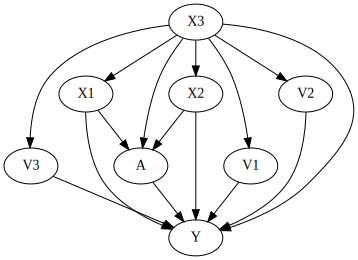

In [36]:
g = gr.Digraph()
g.edge("X3", "V3"),g.edge("X3", "X1"),g.edge("X3", "X2"),g.edge("X3", "V1"),g.edge("X3","V2"),g.edge("X1", "A"),g.edge("X2", "A"),g.edge("X3", "A"),g.edge("V1", "Y"),g.edge("V2", "Y"),g.edge("V3", "Y"),g.edge("X1", "Y"),g.edge("X2", "Y"),g.edge("X3", "Y"),g.edge("A", "Y")
g

###Question 4

**(4.1)**

In [39]:
def cond_mean_OLS(df, covariate_variable_l):
  # Select dataframe
  df0 = df[df["A"] == 0]
  df1 = df[df["A"] == 1]
  
  # Control
  control_ols = sm.OLS(df0["Y"], sm.add_constant(df0[covariate_variable_l], has_constant='add'))
  control_reg = control_ols.fit()
  mu0_hat = control_reg.predict(sm.add_constant(df[covariate_variable_l], has_constant='add'))
  # Treatment
  treatment_ols = sm.OLS(df1["Y"], sm.add_constant(df1[covariate_variable_l], has_constant='add'))
  treatment_reg = treatment_ols.fit()
  mu1_hat = treatment_reg.predict(sm.add_constant(df[covariate_variable_l], has_constant='add'))
        
  return (np.array(mu1_hat) - np.array(mu0_hat)).mean()

In [41]:
cond_mean_OLS(simul_pe_data, ["X1","X2","X3"])

2.0973497278647772

**(4.2)**

In [42]:
cond_mean_OLS(simul_pe_data, ["X1","X3"])

1.447630296281124

###Question 5

In [46]:
def clip_probabilities(prob, th=0.1) :
  prob[prob < th] = th
  prob[prob > (1-th)] = 1-th
  return prob 

   
def estimate_ipw_weights(df, covariate_variable_l, is_parametric, clip_probabilities=False):
  if is_parametric:
    # estimate propensity scores without and with extended set
    propensity_model = sklearn_linear_model.LogisticRegression(random_state=0, fit_intercept=True).fit(df[covariate_variable_l], df["A"])
  else:
    propensity_model = sklearn_ensemble.RandomForestClassifier(n_estimators = 100, random_state = 0, min_samples_leaf=1).fit(df[covariate_variable_l], df["A"])
  estimates_prob = propensity_model.predict_proba(df[covariate_variable_l])[:, 1]
  if clip_probabilities:
    estimates_prob = clip_probabilities(estimates_prob)
  return estimates_prob
        
    
def estimate_ipw(df, covariate_variable_l, is_parametric=True, clip_probabilities=False):
  # compute estimates
  Y = df["Y"].to_numpy()
  A = df["A"].to_numpy()
  e_hat = estimate_ipw_weights(df, covariate_variable_l, is_parametric=is_parametric, clip_probabilities=clip_probabilities)
  return (Y * ((A/e_hat) - (1-A)/(1-e_hat))).mean()

**(5.1)**

In [47]:
estimate_ipw(simul_pe_data, ["X1","X2","X3"])

2.1638599297755996

**(5.2)**

In [48]:
estimate_ipw(simul_pe_data, ["X1","X3"])

1.4163393321890445

There is a bias when omitting confounding variables. The identifiability assumption is not met.

### Question 6



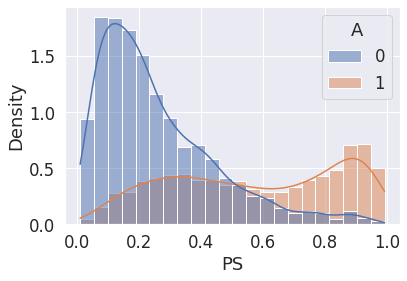

In [49]:
overlap_weights = estimate_ipw_weights(simul_pe_data, ["X1", "X2", "X3"], is_parametric=True)
viz_overlap_df = pd.DataFrame({"A": simul_pe_data["A"], "PS": pd.Series(overlap_weights)})
sns.histplot(data=viz_overlap_df, x='PS', hue='A', kde=True, stat="density");

The overlap identifiability assumption seems met. Each observation has a non null probability to be treated (even if the treated have a larger probability to be treated than the non treated). 



### Question 7



In [58]:
DIST_CAT_PLOT_PARAMS_D = {"height": 14, "aspect": .8}

In [59]:
# Simulation parameters
PARAMETRIC_METHODS = ["Parametric G-formula - X",
                       "Parametric G-formula - XV",
                       "Parametric G-formula - misspecified",
                       "Parametric IPW - X",
                       "Parametric IPW - XV",
                       "Parametric IPW - misspecified"
                     ]

NONPARAMETRIC_METHODS = ["Nonparametric G-formula - X",
                          "Nonparametric G-formula - XV",
                          "Nonparametric G-formula - misspecified",
                          "Nonparametric IPW - X",
                          "Nonparametric IPW - XV",
                          "Nonparametric IPW - misspecified"
                        ]

**(7.1)**

In [60]:
def simulate_multiple_models(method_l:list, is_parametric:bool=False, clip_probabilities:bool=False, n_datapoints_per_simulation:int=5000) -> pd.DataFrame:
    estimate_l = []
    for i in range(100):
        # Generate data from the true distribution
        dataframe_simulation = generate_lunceford(n = n_datapoints_per_simulation)

        # Difference in means
        estimates_md = difference_in_means(dataframe_simulation)

        # G-formula
        estimates_x_gformula = cond_mean_OLS(dataframe_simulation, ["X1", "X2", "X3"])
        estimates_xv_gformula = cond_mean_OLS(dataframe_simulation, ["X1", "X2", "X3", "V1", "V2", "V3"])
        estimates_miss_gformula = cond_mean_OLS(dataframe_simulation, ["X1", "X3"])

        # IPW 
        estimates_x_ipw = estimate_ipw(dataframe_simulation, ["X1", "X2", "X3"], is_parametric=is_parametric, clip_probabilities=clip_probabilities)
        estimates_v_ipw = estimate_ipw(dataframe_simulation, ["V1", "V2", "V3"], is_parametric=is_parametric, clip_probabilities=clip_probabilities)
        estimates_xv_ipw = estimate_ipw(dataframe_simulation, ["X1", "X2", "X3", "V1", "V2", "V3"], is_parametric=is_parametric, clip_probabilities=clip_probabilities)
        estimates_miss_ipw = estimate_ipw(dataframe_simulation, ["X1", "X3"], is_parametric=is_parametric, clip_probabilities=clip_probabilities)

        estimate_l += [#estimates_md,
                               estimates_x_gformula, 
                               estimates_xv_gformula, 
                               estimates_miss_gformula,
                               estimates_x_ipw,
                               estimates_xv_ipw,
                               estimates_miss_ipw]
    
    return pd.DataFrame({"estimate": estimate_l, "method": np.tile(method_l, 100), "n_datapoints_per_simulation": np.ones(100 * len(method_l), dtype=int) * n_datapoints_per_simulation})

In [51]:
parametric_simulations_5000 = simulate_multiple_models(PARAMETRIC_METHODS, is_parametric=True, clip_probabilities=False, n_datapoints_per_simulation=5000)

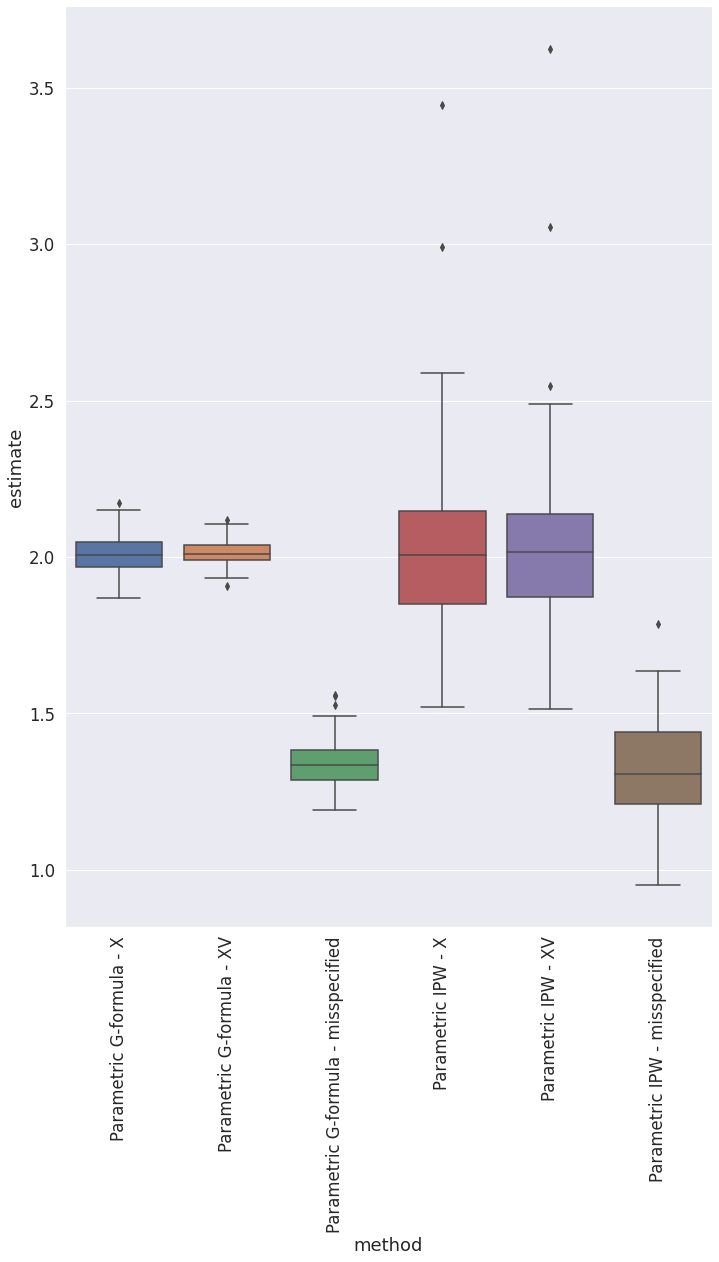

In [62]:
g = sns.catplot(x="method", y="estimate", data=parametric_simulations_5000, kind="box",**DIST_CAT_PLOT_PARAMS_D);
g.set_xticklabels(rotation=90)

The parametric IPW and g-formula when using $X_1$, $X_2$ and $X_3$ are unbiased. The variance of the IPW estimator is larger; this is expected as this estimator is highly variable as its variance depends of the inverse of the propensity score. Consequently, when overlap is not large or when some probabilities to be treated or non treated are close to 1, the estimator is unstable. Normalized IPW can be an alternative to stabilize the estimator. 
When adding the variables $V_1$, $V_2$, $V_3$ for the g-estimator, one can see that the variance decreases. 
When the models are mispecified (identifiability assumptions are not met as we do not include all the confounders), there is a large bias for both estimators.

**(7.2)** Answer Question **(7.1)** using different number of datapoints `n_datapoints_per_simulation` for instance 100, 1000, 10000. Comment.

In [53]:
parametric_simulations_1000 = simulate_multiple_models(PARAMETRIC_METHODS, is_parametric=True, clip_probabilities=False, n_datapoints_per_simulation=1000)
parametric_simulations_10000 = simulate_multiple_models(PARAMETRIC_METHODS, is_parametric=True, clip_probabilities=False, n_datapoints_per_simulation=10000)

In [54]:
vis_7_df = pd.concat([parametric_simulations_1000, parametric_simulations_10000], axis=0)

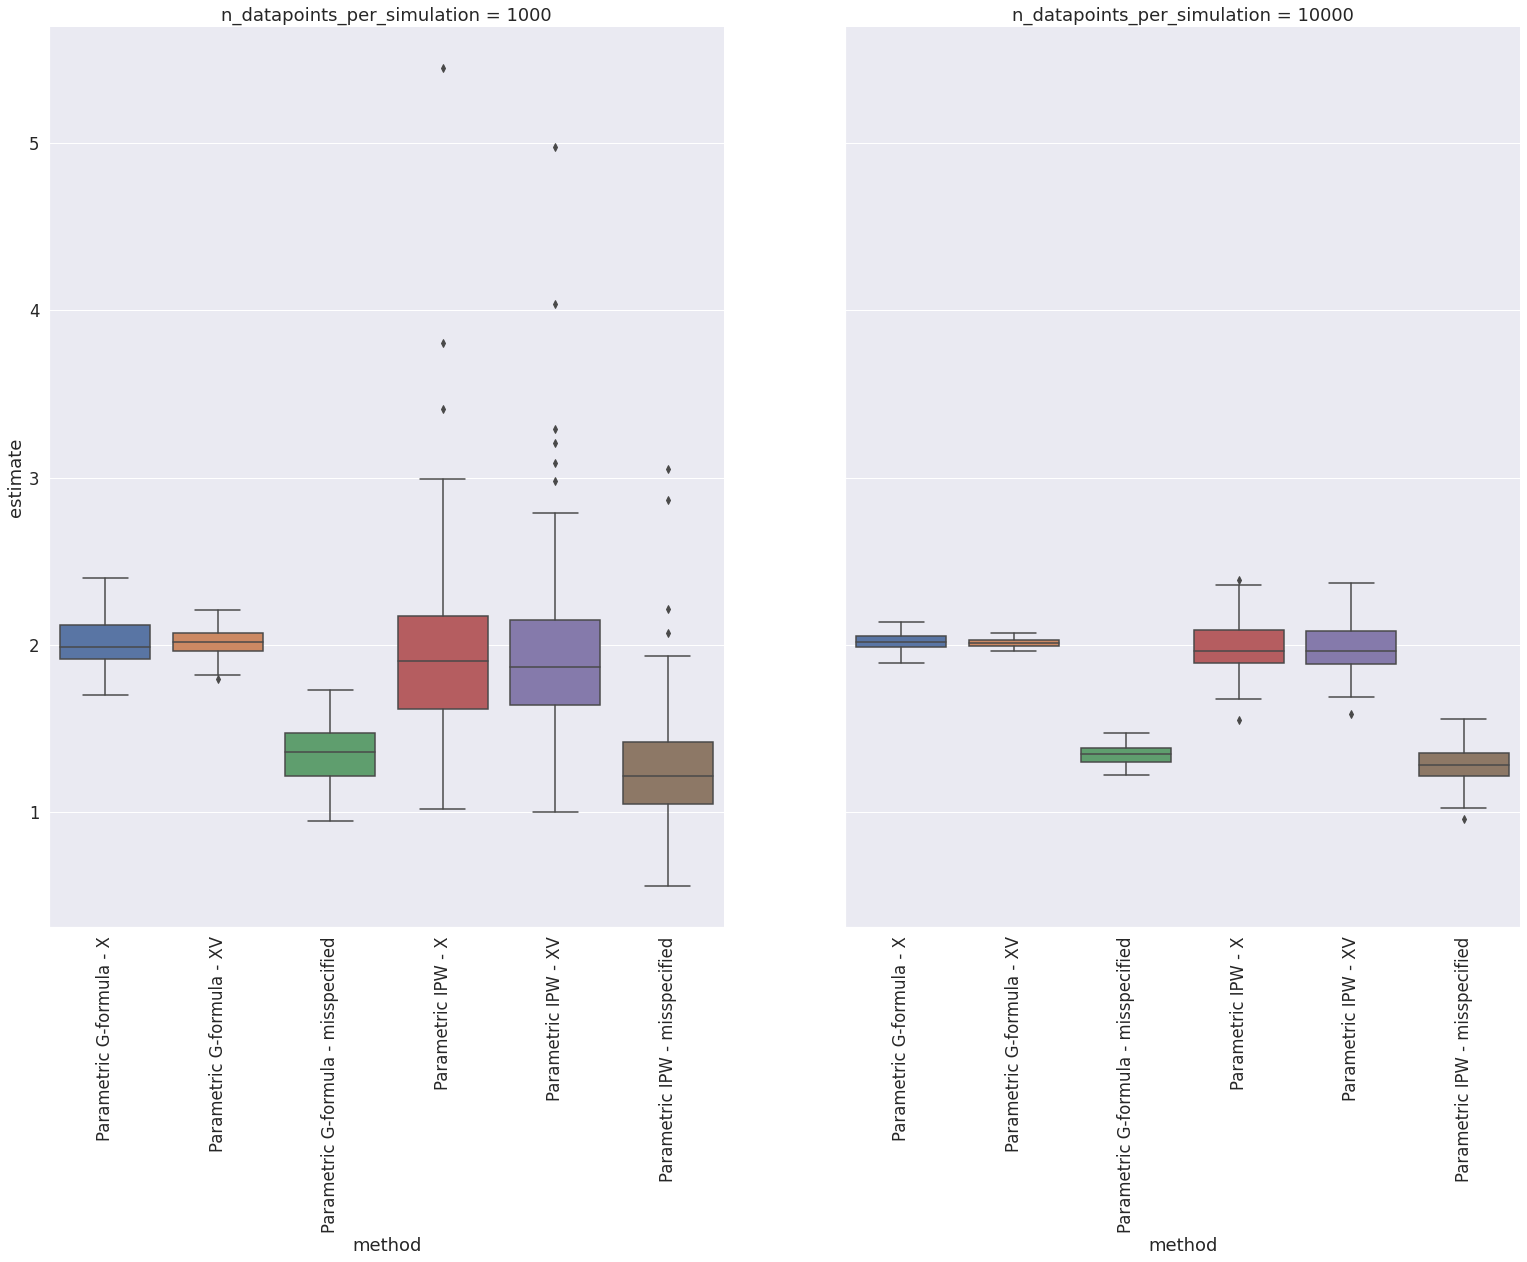

In [63]:
g = sns.catplot(x="method", y="estimate", col="n_datapoints_per_simulation", data=vis_7_df, kind="box",**DIST_CAT_PLOT_PARAMS_D)
g.set_xticklabels(rotation=90)

When the sample size increases, the variance decreases. Note that it does not improve on the bias for the mispecified models. 

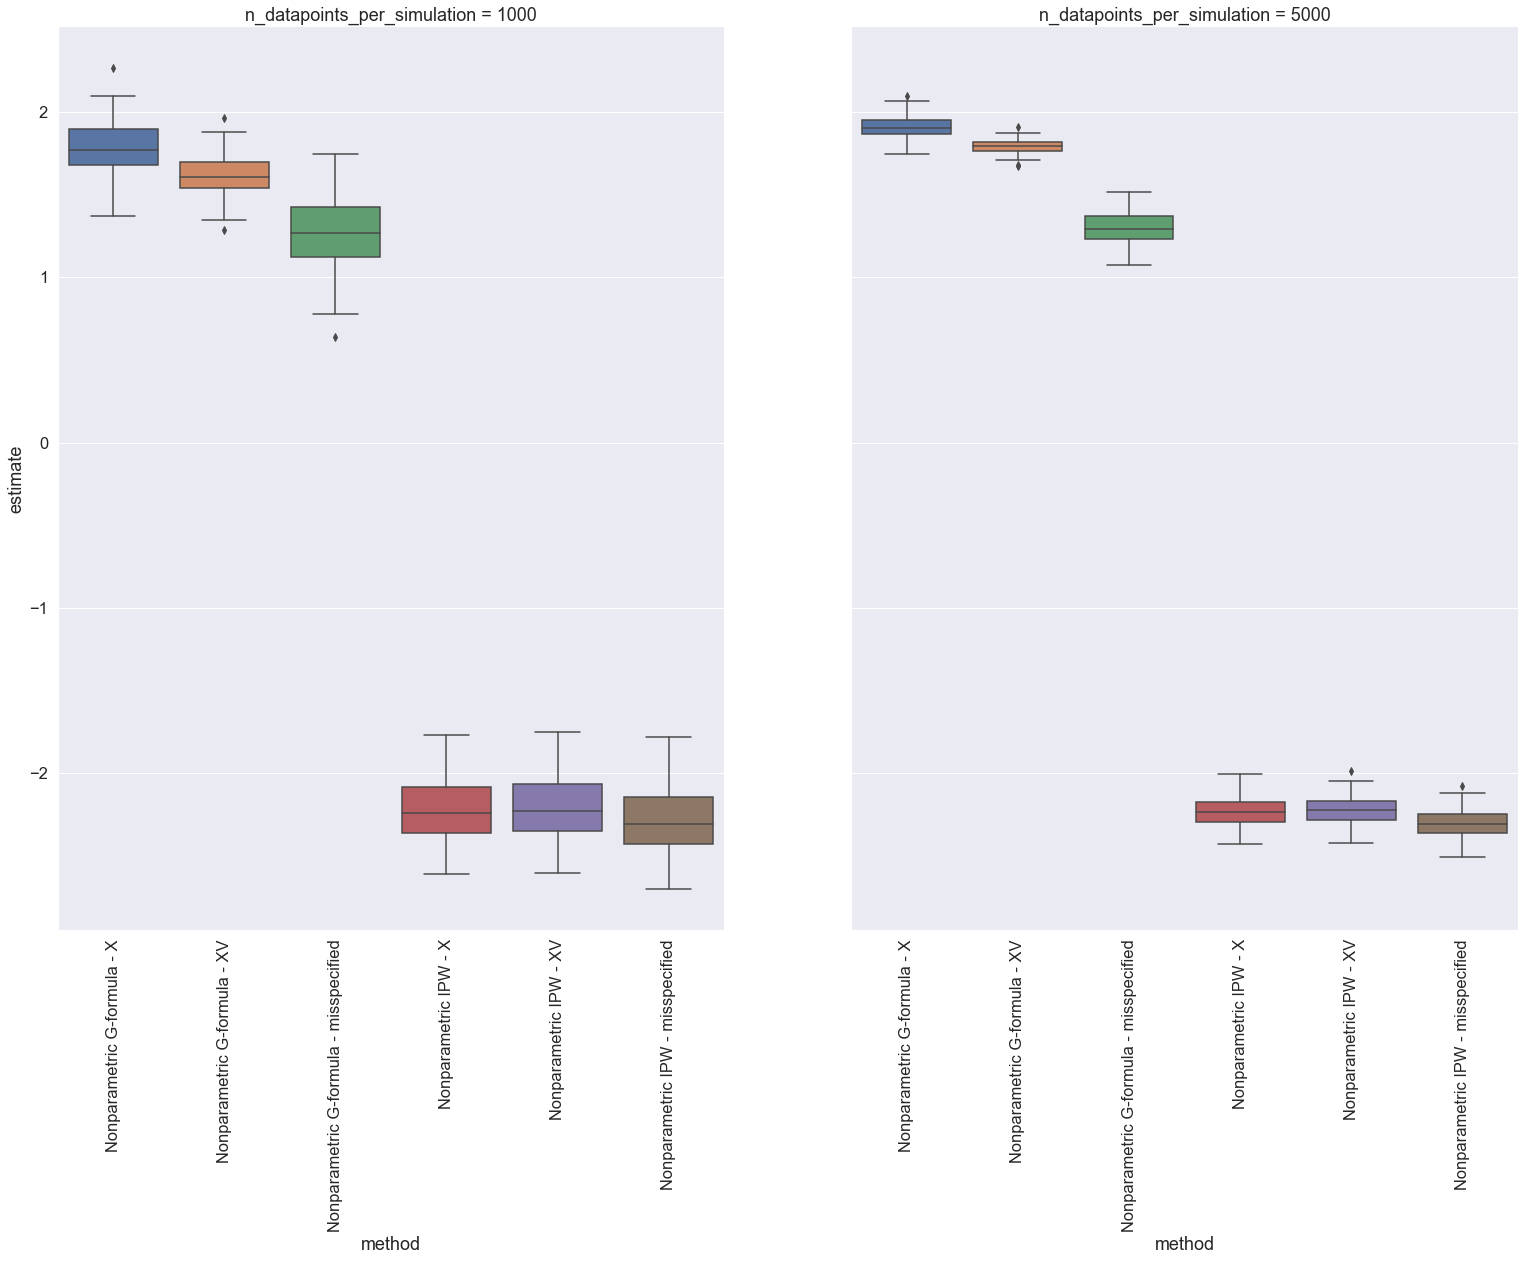

In [ ]:
g = sns.catplot(x="method", y="estimate", col="n_datapoints_per_simulation", data=vis_9_df, kind="box");
g.set_xticklabels(rotation=90)